
... ***CURRENTLY UNDER DEVELOPMENT*** ...


# Compare offshore waves that are already propagated nearshore (SWAN) with waves from the climate emulator

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, Aggregate_WavesFamilies

from teslakit.plotting.outputs import Plot_FitSim_Histograms
from teslakit.plotting.extremes import Plot_FitSim_AnnualMax, Plot_FitSim_GevFit, Plot_Fit_QQ

from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim


In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'

db = Database(p_data)

# set site
db.SetSite('KWAJALEIN_emulator')


## Load MDA of historical offshore waves

In [3]:
import pandas as pd

hist_mda_sea = pd.read_pickle('/Users/albacid/Projects/SERDP/inputs_Kwajalein/waves_offshore_historical_swells_MDA/sea_subset.pkl')
hist_mda_sea = hist_mda_sea.to_xarray()
print(hist_mda_sea)
print()

hist_mda_swells = pd.read_pickle('/Users/albacid/Projects/SERDP/inputs_Kwajalein/waves_offshore_historical_swells_MDA/swell_subset.pkl')
hist_mda_swells = hist_mda_swells.to_xarray()
print(hist_mda_swells)

<xarray.Dataset>
Dimensions:  (index: 500)
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
Data variables:
    hs       (index) float64 5.934 0.2422 0.8587 0.05692 ... 0.942 1.028 1.661
    tp       (index) float64 8.344 2.235 14.28 2.645 ... 2.09 4.405 6.527 6.338
    dir      (index) float64 151.6 331.2 7.697 255.2 ... 58.0 116.2 236.8 37.19
    spr      (index) float64 49.72 29.91 15.93 75.45 ... 32.0 31.73 34.45 38.98
    gamma    (index) float64 10.17 100.0 1.0 4.724 ... 68.86 25.85 2.794 3.011

<xarray.Dataset>
Dimensions:  (index: 500)
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
Data variables:
    tp       (index) float64 27.12 4.709 2.239 9.809 ... 10.34 3.705 8.72 12.11
    dir      (index) float64 189.2 46.38 163.1 205.0 ... 151.5 204.9 46.52 143.7
    spr      (index) float64 4.83 32.61 38.26 12.33 ... 14.57 16.01 18.17 33.84
    gamma    (index) float64 74.13 3.108 100.0 7.376 .

## Load waves from the climate emulator

In [4]:
# Full simulation

CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)

WVS_sim_upd = CE.LoadSim_All(TCs=True)
WVS_sim_upd = WVS_sim_upd.to_xarray()


#----------------------------------------------------------
# Poner NaN en WVS_upd_E donde Hs, Tp y Dir de Swell_1 y Swell_2 valen 0 (Hubo TC y sólo tenemos Sea family)
vars = {'swell_1_Hs','swell_1_Tp','swell_1_Dir','swell_2_Hs','swell_2_Tp','swell_2_Dir'}
for var in vars:
    WVS_sim_upd[var] = WVS_sim_upd[var].where(WVS_sim_upd[var]!=0.00, np.nan)


print(WVS_sim_upd)


<xarray.Dataset>
Dimensions:      (index: 1032644)
Coordinates:
  * index        (index) int64 0 1 2 3 4 ... 1032640 1032641 1032642 1032643
Data variables:
    DWT          (index) float32 28.0 1.0 32.0 33.0 41.0 ... 13.0 28.0 20.0 20.0
    sea_Hs       (index) float32 1.5582333 2.434917 ... 1.810582 2.2550507
    sea_Tp       (index) float32 7.720595 8.870701 ... 8.210051 6.6658435
    sea_Dir      (index) float32 54.23647 70.633 ... 56.327915 67.612114
    swell_1_Hs   (index) float32 0.84767956 0.86827296 ... 0.3111764 0.42345622
    swell_1_Tp   (index) float32 8.847652 6.94969 ... 9.856896 11.085974
    swell_1_Dir  (index) float32 68.4031 97.40611 45.76165 ... 73.13391 72.43033
    swell_2_Hs   (index) float32 0.35236874 0.28442293 ... 0.45500863 0.26068825
    swell_2_Tp   (index) float32 11.0032215 12.334754 ... 11.017166 9.1800585
    swell_2_Dir  (index) float32 179.73355 171.34354 ... 179.41365 171.41524
    mu           (index) float32 0.8968535 0.8001056 0.9437985 ... 0.0

## Load historical TC offshore waves

In [5]:
TC_hist_offsh = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/TCs_offshore/historical_TCs/all_historical_TCs/output_nonstat_nest_pts.nc')

TC_hist_offsh = TC_hist_offsh.drop({'DEP','TM02','DSPR','WIND','OUT','x_point', 'y_point','WATLEV'})
TC_hist_offsh = TC_hist_offsh.drop({'HSWELL'}) # tb se descarta porque solo simulamos TCs cerca del site??

TC_hist_offsh = TC_hist_offsh.squeeze()
print(TC_hist_offsh)


<xarray.Dataset>
Dimensions:  (case: 64, time: 12683)
Coordinates:
  * time     (time) datetime64[ns] 1951-03-18T18:40:00 ... 2015-07-05T20:40:00
  * case     (case) int64 0 1 2 3 4 5 6 7 8 9 ... 54 55 56 57 58 59 60 61 62 63
Data variables:
    HS       (case, time) float64 ...
    DIR      (case, time) float64 ...
    RTP      (case, time) float64 ...



## Load MDA of Synthetic TC offshore waves

In [6]:
# OFFSHORE TC waves (500 TCs are simulated with non stationary SWAN at 2 different time steps)
TCs_sims_offsh_10 = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/TCs_offshore/MDA500/output_nonstat_pts_dt10.nc')
TCs_sims_offsh_20 = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/TCs_offshore/MDA500/output_nonstat_pts_dt20.nc')

TCs_sims_offsh_20 = TCs_sims_offsh_20.resample(time='10Min').interpolate('linear')
TCs_sims_offsh = xr.concat([TCs_sims_offsh_10,TCs_sims_offsh_20], dim="case")
#TCs_sims.to_netcdf('/Users/albacid/Projects/SERDP/inputs_Kwajalein/TCs/MDA500/output_nonstat_pts.nc')

TCs_sims_offsh = TCs_sims_offsh.drop({'DEP','TM02','DSPR','WIND','OUT','x_point', 'y_point','WATLEV'})
TCs_sims_offsh = TCs_sims_offsh.drop({'HSWELL'}) # tb se descarta porque solo simulamos TCs cerca del site??
TCs_sims_offsh = TCs_sims_offsh.rename({'case':'storm'})
TCs_sims_offsh = TCs_sims_offsh.squeeze()
print(TCs_sims_offsh)
print()


<xarray.Dataset>
Dimensions:  (storm: 500, time: 2295)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 ... 2020-01-16T22:20:00
  * storm    (storm) int64 0 1 4 5 7 10 11 13 ... 484 486 490 491 497 498 499
Data variables:
    HS       (storm, time) float64 0.0005117 0.0005107 0.0005097 ... nan nan nan
    DIR      (storm, time) float64 297.0 297.1 297.2 297.2 ... nan nan nan nan
    RTP      (storm, time) float64 1.941 1.941 1.941 1.941 ... nan nan nan nan



## Compare data

### compare Sea family

(0.0, 1.0, 0.0, 1.0)

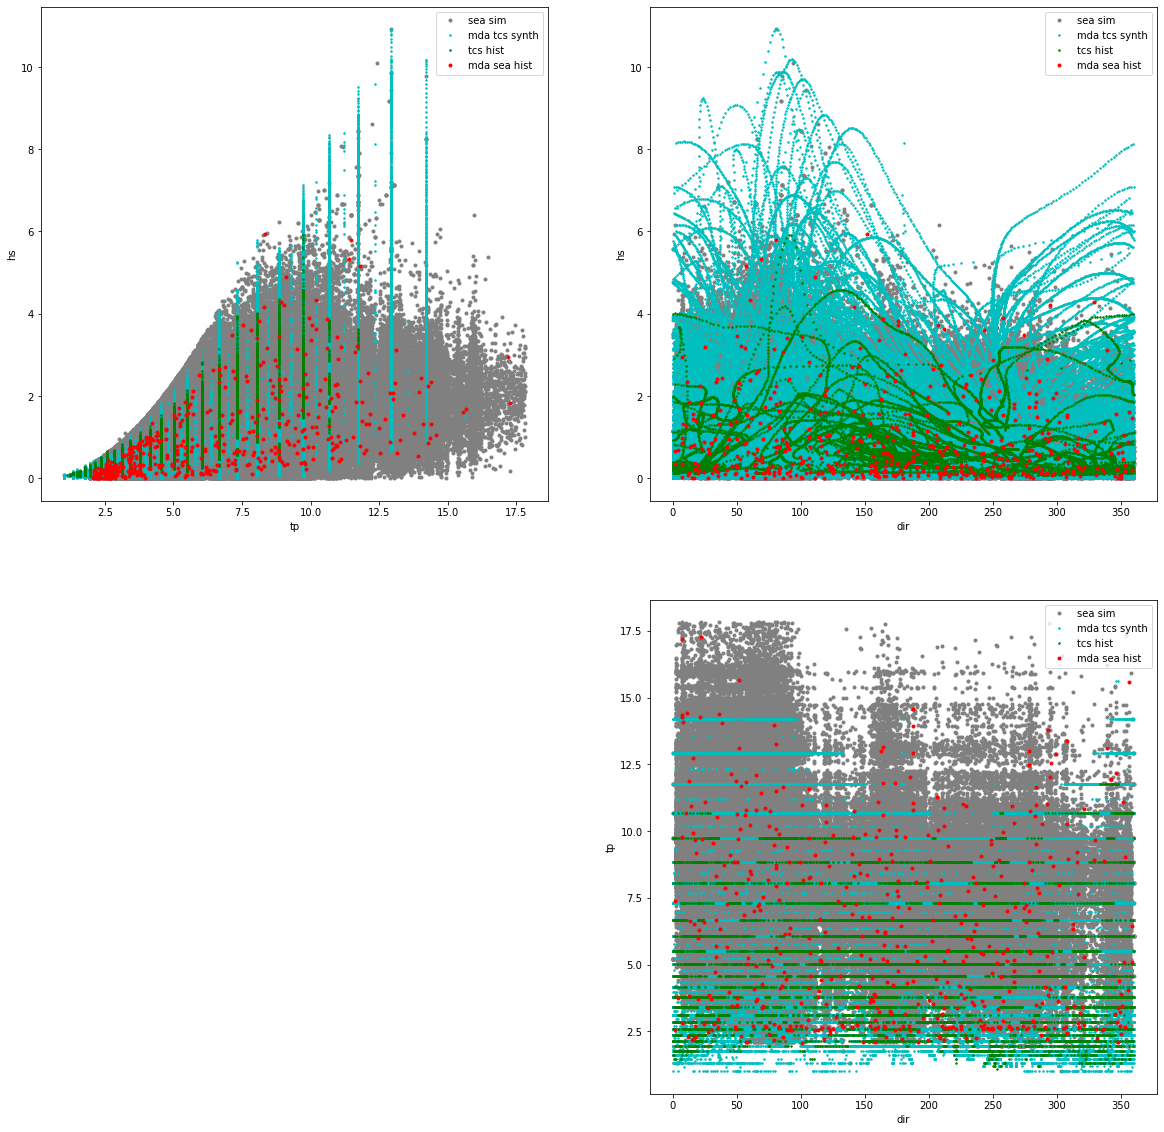

In [7]:
fig,axs = plt.subplots(2,2,figsize=(20,20));

axs[0,0].plot(WVS_sim_upd.sea_Tp, WVS_sim_upd.sea_Hs, '.', color='grey', label='sea sim')
axs[0,0].plot( TCs_sims_offsh.RTP.values[:].flatten(),TCs_sims_offsh.HS.values[:].flatten(), '.c', markersize=3, label='mda tcs synth')
axs[0,0].plot(TC_hist_offsh.RTP.values[:].flatten(),TC_hist_offsh.HS.values[:].flatten(),  '.g', markersize=3,  label='tcs hist')
axs[0,0].plot(hist_mda_sea.tp, hist_mda_sea.hs, '.r', label='mda sea hist')
axs[0,0].legend()
axs[0,0].set_ylabel('hs')
axs[0,0].set_xlabel('tp')


axs[0,1].plot(WVS_sim_upd.sea_Dir, WVS_sim_upd.sea_Hs, '.', color='grey', label='sea sim')
axs[0,1].plot( TCs_sims_offsh.DIR.values[:].flatten(),TCs_sims_offsh.HS.values[:].flatten(), '.c', markersize=3,  label='mda tcs synth')
axs[0,1].plot(TC_hist_offsh.DIR.values[:].flatten(),TC_hist_offsh.HS.values[:].flatten(),  '.g', markersize=3,  label='tcs hist')
axs[0,1].plot( hist_mda_sea.dir, hist_mda_sea.hs, '.r', label='mda sea hist')
axs[0,1].legend()
axs[0,1].set_ylabel('hs')
axs[0,1].set_xlabel('dir')


axs[1,1].plot(WVS_sim_upd.sea_Dir, WVS_sim_upd.sea_Tp, '.', color='grey', label='sea sim')
axs[1,1].plot( TCs_sims_offsh.DIR.values[:].flatten(),TCs_sims_offsh.RTP.values[:].flatten(), '.c', markersize=3,  label='mda tcs synth')
axs[1,1].plot(TC_hist_offsh.DIR.values[:].flatten(),TC_hist_offsh.RTP.values[:].flatten(),  '.g', markersize=3,  label='tcs hist')
axs[1,1].plot( hist_mda_sea.dir, hist_mda_sea.tp, '.r', label='mda sea hist')
axs[1,1].legend()
axs[1,1].set_ylabel('tp')
axs[1,1].set_xlabel('dir')

axs[1, 0].axis('off')

### compare Swells families

Text(0.5, 0, 'dir')

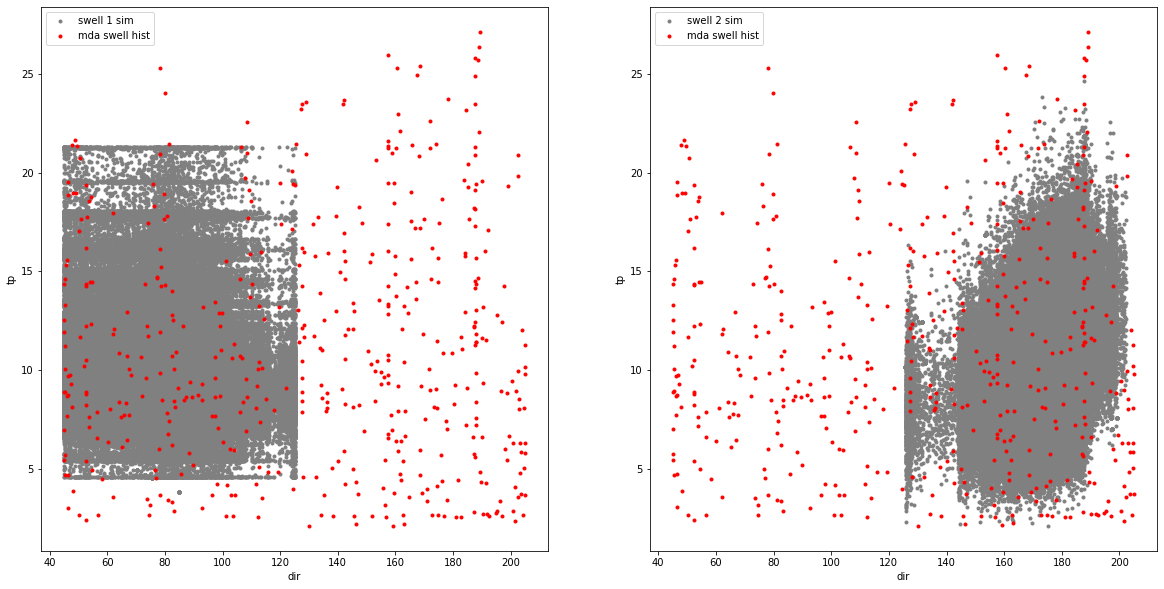

In [8]:

fig,axs = plt.subplots(1,2,figsize=(20,10))

axs[0].plot(WVS_sim_upd.swell_1_Dir, WVS_sim_upd.swell_1_Tp, '.', color='grey', label='swell 1 sim')
axs[0].plot( hist_mda_swells.dir, hist_mda_swells.tp, '.r', label='mda swell hist')
axs[0].legend()
axs[0].set_ylabel('tp')
axs[0].set_xlabel('dir')


axs[1].plot(WVS_sim_upd.swell_2_Dir, WVS_sim_upd.swell_2_Tp, '.', color='grey', label='swell 2 sim')
axs[1].plot( hist_mda_swells.dir, hist_mda_swells.tp, '.r', label='mda swell hist')
axs[1].legend()
axs[1].set_ylabel('tp')
axs[1].set_xlabel('dir')